In [1]:
import sys
sys.path.append('../')
import nexullance.LP_gurobi as LP
import topologies.Slimfly as Slimfly
import globals as gl
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [2]:
config=(32, 6)
EPR=3
topo='slimfly'
_network=Slimfly.Slimflytopo(config[0], config[1])
edge_list=list(_network.nx_graph.edges())


# Uniform traffic

In [3]:
p2p_traffic_matrix=gl.generate_uniform_traffic_pattern(config[0], EPR)
R2R_matrix=gl.convert_p2p_traffic_matrix_to_R2R(p2p_traffic_matrix, config[0], EPR)

nexullance-APST-4

In [4]:
results, _, path_dict = gl.calculate_data_paths_within_length(_network, config, 4)
link_loads, local_link_load=_network.distribute_arbitrary_flow_on_paths_with_EPs(path_dict, EPR, p2p_traffic_matrix)
print(f'predicted saturation load (before optimization) = {local_link_load/max(link_loads)}')
display(results)
all_weighted_paths, result_link_loads=LP.Solve_load_balancing(path_dict, edge_list,R2R_matrix, _verbose=0)
link_loads, local_link_load=_network.distribute_arbitrary_flow_on_weighted_paths_with_EPs(all_weighted_paths, EPR, p2p_traffic_matrix)
print(f'predicted saturation load (after optimization) = {local_link_load/max(link_loads)}')

calculation done for (32, 6) with shorter-than-4 paths routing
predicted saturation load (before optimization) = [0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489 0.54062489
 0.54062489 0.54

{'diameter': 2,
 'ave_path_length_statistics': [3.6923076923076925,
  3.7524480375677043,
  3.8666666666666667],
 'num_paths_statistics': [26, 29.870967741935484, 31],
 'link_load_statistics': [18.70223325062044,
  19.387648194099917,
  19.52473118279586]}

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2411299
Academic license - for non-commercial use only - registered to ziyue.zhang@ugent.be
number of variables = 29824, number of constraints = 1184
Set parameter Threads to value 1
Optimal solution found
Max link load is: 90.0
predicted saturation load (after optimization) = 1.055555555555554


In [5]:
local_link_load

95.0

check the selected path lengths

In [6]:
nexullance_path_length_stat={}
for s_d, weighted_paths in all_weighted_paths.items():
    if R2R_matrix[s_d[0]][s_d[1]]==0:
        continue
    # input_path_len_stat=[]
    paths_stat=[]
    for path, weight in weighted_paths:
        path_length=len(path)-1
        if round(weight, 3)>0:
            paths_stat.append([path_length, weight])
    nexullance_path_length_stat[s_d]=paths_stat

Text(0, 0.5, 'frequency')

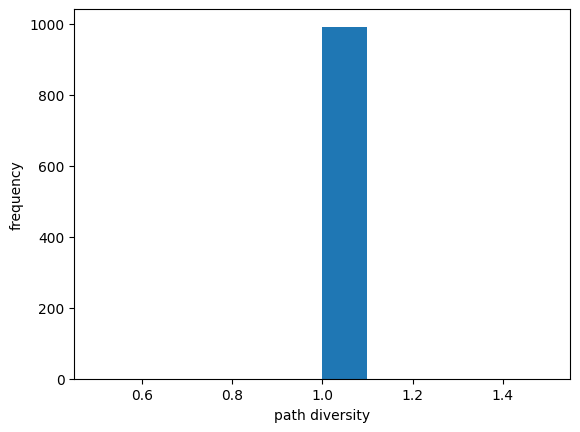

In [7]:
# path diversity
data=[]
for paths_stat in nexullance_path_length_stat.values():
    data.append(len(paths_stat))
plt.hist(data)
plt.xlabel("path diversity")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

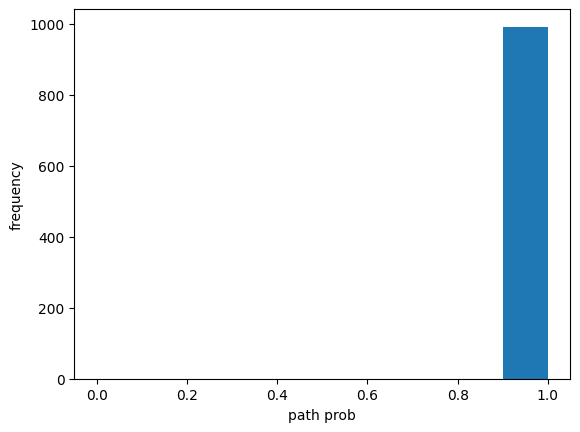

In [8]:
# path prob
data=[]
for paths_stat in nexullance_path_length_stat.values():
    for path_stat in paths_stat:
        data.append(round(path_stat[1], 3))
plt.hist(data, range=(0,1))
plt.xlabel("path prob")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

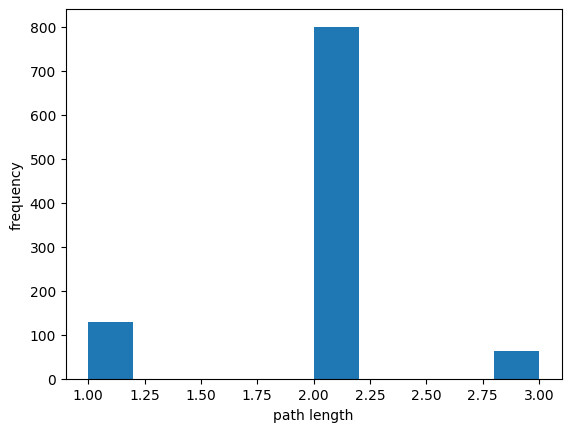

In [9]:
# path length
data=[]
for paths_stat in nexullance_path_length_stat.values():
    for path_stat in paths_stat:
        data.append(path_stat[0])
plt.hist(data)
plt.xlabel("path length")
plt.ylabel("frequency")

Text(0, 0.5, 'path prob')

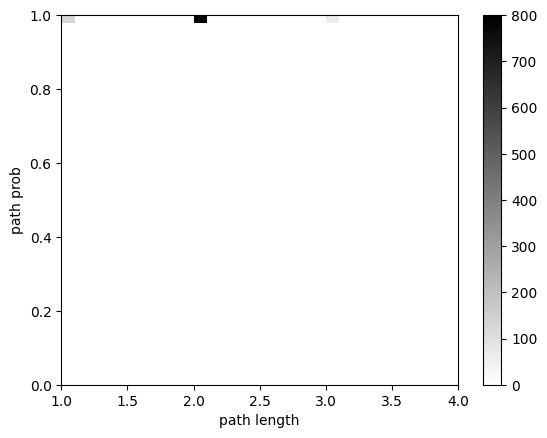

In [10]:
# 2-d: path length and path prob
path_length_data=[]
path_prob_data=[]
for paths_stat in nexullance_path_length_stat.values():
    for path_stat in paths_stat:
        path_length_data.append(path_stat[0])
        path_prob_data.append(round(path_stat[1], 3))
plt.hist2d(path_length_data, path_prob_data,cmap ="binary", range=(((1,4), (0,1))), bins=[30,50])
plt.colorbar()
plt.xlabel("path length")
plt.ylabel("path prob")

Text(0.5, 1.0, 'only s-d with distance=1')

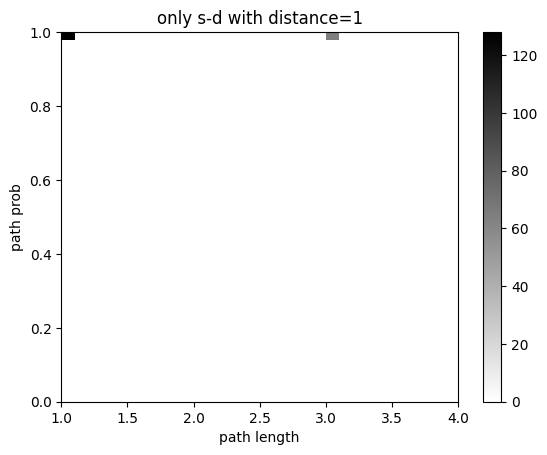

In [11]:
# 2-d: path length and path prob, for those s-d with distance=1
path_length_data=[]
path_prob_data=[]
for (s, d), paths_stat in nexullance_path_length_stat.items():
    if nx.shortest_path_length(_network.nx_graph, s, d)==1:
        for path_stat in paths_stat:
            path_length_data.append(path_stat[0])
            path_prob_data.append(round(path_stat[1], 3))
plt.hist2d(path_length_data, path_prob_data,cmap ="binary", range=(((1,4), (0,1))), bins=[30,50])
plt.colorbar()
plt.clim(0)
plt.xlabel("path length")
plt.ylabel("path prob")
plt.title("only s-d with distance=1")


Text(0.5, 1.0, 'only s-d with distance=2')

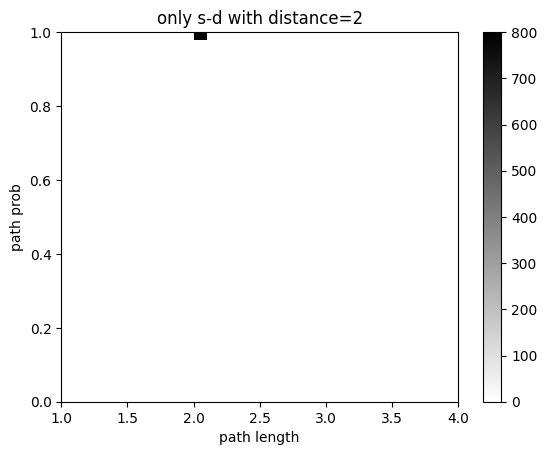

In [12]:
# 2-d: path length and path prob, for those s-d with distance=2
path_length_data=[]
path_prob_data=[]
for (s, d), paths_stat in nexullance_path_length_stat.items():
    if nx.shortest_path_length(_network.nx_graph, s, d)==2:
        for path_stat in paths_stat:
            path_length_data.append(path_stat[0])
            path_prob_data.append(round(path_stat[1], 3))
plt.hist2d(path_length_data, path_prob_data,cmap ="binary", range=(((1,4), (0,1))), bins=[30,50])
plt.colorbar()
plt.clim(0)
plt.xlabel("path length")
plt.ylabel("path prob")
plt.title("only s-d with distance=2")


# Shift traffic

In [13]:
p2p_traffic_matrix=gl.generate_shift_traffic_pattern(config[0], EPR)
R2R_matrix=gl.convert_p2p_traffic_matrix_to_R2R(p2p_traffic_matrix, config[0], EPR)

nexullance-APST-4

In [14]:
results, _, path_dict = gl.calculate_data_paths_within_length(_network, config, 4)
link_loads, local_link_load=_network.distribute_arbitrary_flow_on_paths_with_EPs(path_dict, EPR, p2p_traffic_matrix)
print(f'predicted saturation load (before optimization) = {local_link_load/max(link_loads)}')
display(results)
all_weighted_paths, result_link_loads=LP.Solve_load_balancing(path_dict, edge_list,R2R_matrix, _verbose=0)
link_loads, local_link_load=_network.distribute_arbitrary_flow_on_weighted_paths_with_EPs(all_weighted_paths, EPR, p2p_traffic_matrix)
print(f'predicted saturation load (after optimization) = {local_link_load/max(link_loads)}')

calculation done for (32, 6) with shorter-than-4 paths routing
predicted saturation load (before optimization) = [0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617 0.4092617
 0.4092617 0.4092617 0.4092617 0.40

{'diameter': 2,
 'ave_path_length_statistics': [3.6923076923076925,
  3.7524480375677043,
  3.8666666666666667],
 'num_paths_statistics': [26, 29.870967741935484, 31],
 'link_load_statistics': [18.70223325062044,
  19.387648194099917,
  19.52473118279586]}

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2411299
Academic license - for non-commercial use only - registered to ziyue.zhang@ugent.be
number of variables = 29824, number of constraints = 1184
Set parameter Threads to value 1
Optimal solution found
Max link load is: 1.4999999999999996
predicted saturation load (after optimization) = 0.6666666666666593


check the selected path lengths

In [15]:
nexullance_path_length_stat={}
for s_d, weighted_paths in all_weighted_paths.items():
    if R2R_matrix[s_d[0]][s_d[1]]==0:
        continue
    # input_path_len_stat=[]
    paths_stat=[]
    for path, weight in weighted_paths:
        path_length=len(path)-1
        if round(weight, 3)>0:
            paths_stat.append([path_length, weight])
    nexullance_path_length_stat[s_d]=paths_stat

Text(0, 0.5, 'frequency')

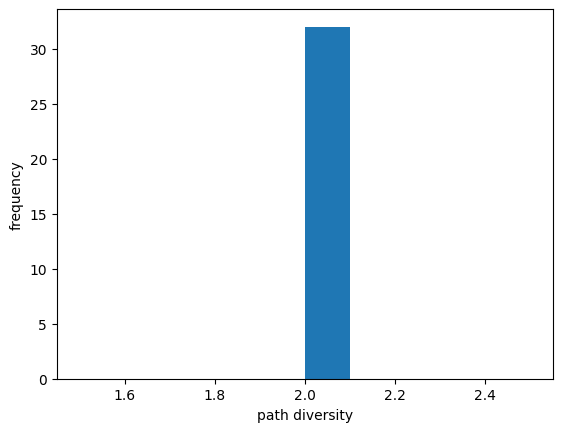

In [16]:
# path diversity
data=[]
for paths_stat in nexullance_path_length_stat.values():
    data.append(len(paths_stat))
plt.hist(data)
plt.xlabel("path diversity")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

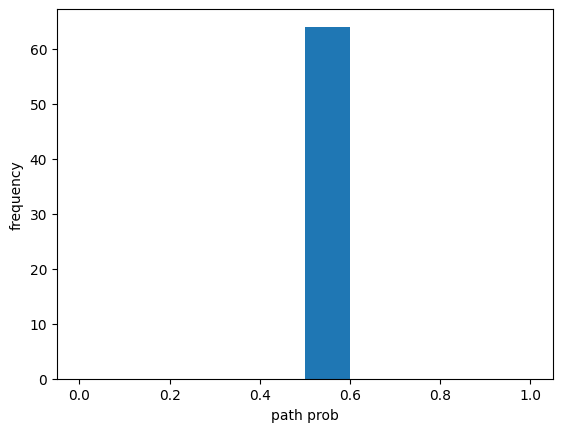

In [17]:
# path prob
data=[]
for paths_stat in nexullance_path_length_stat.values():
    for path_stat in paths_stat:
        data.append(round(path_stat[1], 3))
plt.hist(data, range=(0,1))
plt.xlabel("path prob")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

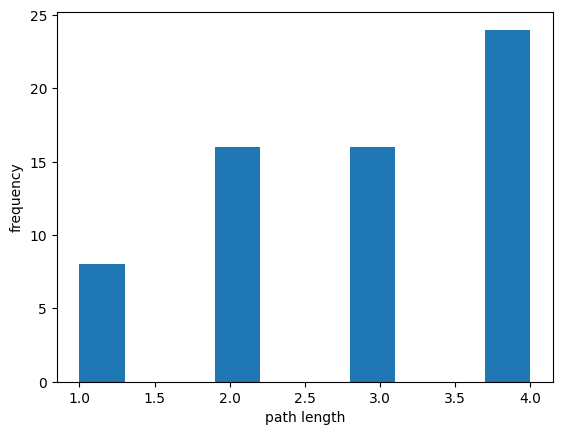

In [18]:
# path length
data=[]
for paths_stat in nexullance_path_length_stat.values():
    for path_stat in paths_stat:
        data.append(path_stat[0])
plt.hist(data)
plt.xlabel("path length")
plt.ylabel("frequency")

Text(0, 0.5, 'path prob')

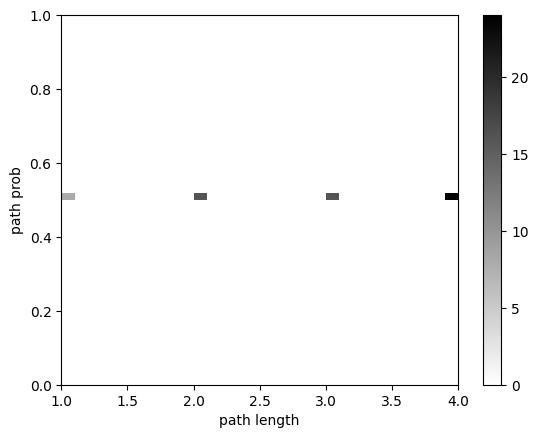

In [19]:
# 2-d: path length and path prob
path_length_data=[]
path_prob_data=[]
for paths_stat in nexullance_path_length_stat.values():
    for path_stat in paths_stat:
        path_length_data.append(path_stat[0])
        path_prob_data.append(round(path_stat[1], 3))
plt.hist2d(path_length_data, path_prob_data,cmap ="binary", range=(((1,4), (0,1))), bins=[30,50])
plt.colorbar()
plt.xlabel("path length")
plt.ylabel("path prob")

Text(0.5, 1.0, 'only s-d with distance=1')

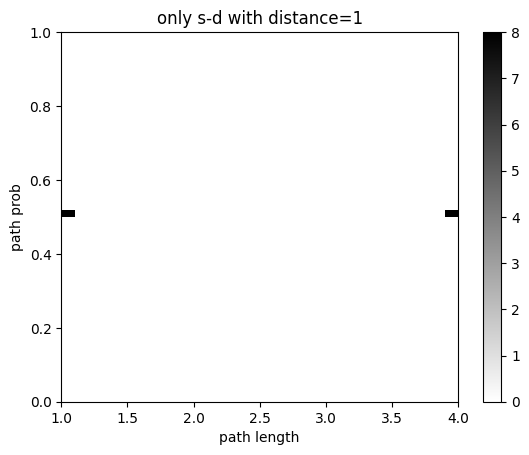

In [20]:
# 2-d: path length and path prob, for those s-d with distance=1
path_length_data=[]
path_prob_data=[]
for (s, d), paths_stat in nexullance_path_length_stat.items():
    if nx.shortest_path_length(_network.nx_graph, s, d)==1:
        for path_stat in paths_stat:
            path_length_data.append(path_stat[0])
            path_prob_data.append(round(path_stat[1], 3))
plt.hist2d(path_length_data, path_prob_data,cmap ="binary", range=(((1,4), (0,1))), bins=[30,50])
plt.colorbar()
plt.clim(0)
plt.xlabel("path length")
plt.ylabel("path prob")
plt.title("only s-d with distance=1")


Text(0.5, 1.0, 'only s-d with distance=2')

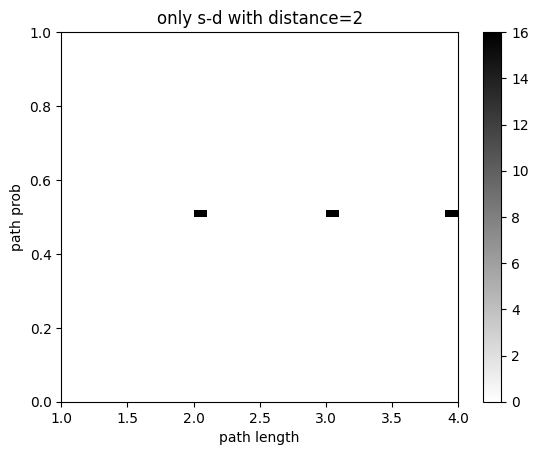

In [21]:
# 2-d: path length and path prob, for those s-d with distance=2
path_length_data=[]
path_prob_data=[]
for (s, d), paths_stat in nexullance_path_length_stat.items():
    if nx.shortest_path_length(_network.nx_graph, s, d)==2:
        for path_stat in paths_stat:
            path_length_data.append(path_stat[0])
            path_prob_data.append(round(path_stat[1], 3))
plt.hist2d(path_length_data, path_prob_data,cmap ="binary", range=(((1,4), (0,1))), bins=[30,50])
plt.colorbar()
plt.clim(0)
plt.xlabel("path length")
plt.ylabel("path prob")
plt.title("only s-d with distance=2")
